# Operate First Community Metrics

In this notebook, we would like to analyze the Operate First Community by collecting and visualizing GitHub metrics from [Augur](https://github.com/chaoss/augur). Augur is a software suite for collecting and measuring structured data about free and open-source software (FOSS) communities. It gathers trace data for a group of repositories or a GitHub organization, normalizes it into a data model, and provides a variety of metrics about the said data.

Some of the metrics we would like to focus in this notebook are:
1. **Community Vitality (Size & Growth)** - All the metrics that can be used to measure both the size and growth of the community such as number of users, number of contributors, number of projects deployed on Operate First, how many new users do we onboard every month, number of issues submitted over time, number of PRs merged over time etc

2. **Impact** - Metrics that can be used to understand the impact made by the Operate First community such as how many upstream issues were opened, upstream contributions etc

In [1]:
# Import required packages
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import json
import os
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime, timezone
sns.set(rc={'figure.figsize':(15,5)})

with open("config_temp.json") as config_file:
    config = json.load(config_file)

# Connect to Augur Database
We will need to connect to the Augur database which has been configured to fetch the Operate First GitHub data. The database configurations need to be specified in the `config.json` file. The database schema we will be using is the `augur_data` schema. You can learn more about the schema here: https://github.com/sandiego-rh/sandiego/blob/master/schema.png.

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Retrieve Available Respositories

In [3]:
repolist = pd.DataFrame()
repo_query = salc.sql.text(f"""
             SET SCHEMA 'augur_data';
             SELECT a.rg_name,
                a.repo_group_id,
                b.repo_name,
                b.repo_id,
                b.forked_from,
                b.repo_archived,
                b.repo_git
            FROM
                repo_groups a,
                repo b
            WHERE
                a.repo_group_id = b.repo_group_id
            ORDER BY
                rg_name,
                repo_name;
    """)
repolist = pd.read_sql(repo_query, con=engine)
display(repolist)
repolist.dtypes

,rg_name,repo_group_id,repo_name,repo_id,forked_from,repo_archived,repo_git
0,operate-first,25155,alertmanager-github-receiver,25434,m-lab/alertmanager-github-receiver,0,https://github.com/operate-first/alertmanager-...
1,operate-first,25155,alerts,25431,Parent not available,0,https://github.com/operate-first/alerts
2,operate-first,25155,apps,25450,Parent not available,0,https://github.com/operate-first/apps
3,operate-first,25155,argocd-apps,25454,Parent not available,1,https://github.com/operate-first/argocd-apps
4,operate-first,25155,blueprint,25442,Parent not available,0,https://github.com/operate-first/blueprint
5,operate-first,25155,common,25436,Parent not available,0,https://github.com/operate-first/common
6,operate-first,25155,community,25430,Parent not available,0,https://github.com/operate-first/community
7,operate-first,25155,community-handbook,25455,Parent not available,0,https://github.com/operate-first/community-han...
8,operate-first,25155,continuous-delivery,25445,Parent not available,0,https://github.com/operate-first/continuous-de...
9,operate-first,25155,continuous-deployment,25453,Parent not available,0,https://github.com/operate-first/continuous-de...


rg_name          object
repo_group_id     int64
repo_name        object
repo_id           int64
forked_from      object
repo_archived     int64
repo_git         object
dtype: object

In [4]:
# Make Operate First repo lists to filter for following sql queries
repo_id_name = repolist[repolist['rg_name']=="operate-first"][['repo_id', 'repo_git']]
repo_id_list = repo_id_name['repo_id'].tolist()
print("Number of repositories in Operate First Organization:", len(repo_id_list))

Number of repositories in Operate First Organization: 26


In [5]:
repolist_columns = ['repo_id', 'repo_name']
repolist = repolist[repolist_columns]
repolist.head()

,repo_id,repo_name
0,25434,alertmanager-github-receiver
1,25431,alerts
2,25450,apps
3,25454,argocd-apps
4,25442,blueprint


Now that we have each of the Operate First repositories and their associated repository IDs, we can start fetching the different types of metrics and analyzing them by categories such as Contributors, Issues and PRs.

# Contributors
In order to measure the size and growth of the Operate First community, we can look at our contributor population base and identify the trend in the growth of our community. We can also further distinguish between "internal" and "external" contributors.

1. Internal Contributors - Core contributors part of the Operate First team
2. External Contributors - All contributors outside of the Operare First team

In [6]:
# Identify the list of internal contributors
internal_contributors = ['Aakanksha Duggal','Alice Saparov','Anand Sanmukhani','Bill Burns','Christoph Görn','Francesco Murdaca','Fridolín Pokorný','Gagan Kumar','Harshad Reddy Nalla','Heidi Picher Dempsey','Hema Veeradhi',
 'Humair','Isabel Zimmerman','Karanraj Chauhan','Karsten Wade','Lars Kellogg-Stedman','LeihaoChen','Marcel Hild','Margaret Haley','Michael Clifford','Michal Drla','Oindrilla Chatterjee','Operate First','Shrey','Surbhi Kanthed','Surya Prakash Pathak','Thoth Bot','Tom Coufal']

Now, we will fetch the data from the `contributors` table which contains information pertaining to the contributors such as their names, GitHub ID, contributor ID etc.

In [7]:
contributors = pd.DataFrame()

repo_query = salc.sql.text(f"""
             SET SCHEMA 'augur_data';
             SELECT * FROM contributors
    """)

contributors = pd.read_sql(repo_query, con=engine)

In [8]:
# Retain only relevant columns of interest
contributors_columns = ['cntrb_id', 'cntrb_full_name', 'gh_user_id']
contributors = contributors[contributors_columns]
# Add another column to identify whether a user is an internal or external contributor
contributors['cntrb_internal'] = contributors['cntrb_full_name'].apply(lambda x: x in internal_contributors)
#contributors = contributors.dropna()
contributors

,cntrb_id,cntrb_full_name,gh_user_id,cntrb_internal
0,1,None,1,False
1,277128,Hema Veeradhi,7343099,True
2,277109,Tom Coufal,7453394,True
3,277117,Christoph Görn,260331,True
4,277114,Harshad Reddy Nalla,14028058,True
...,...,...,...,...
255,277590,Gerrod Thomas,865932,False
256,277156,Gagan Kumar,47332731,True
257,277535,Yaniv Kaul,4655593,False
258,277565,None,49317403,False


### Internal vs External Contributors
Let's see the distribution of internal vs external contributors

In [9]:
contributors['cntrb_internal'].value_counts()

False    232
True      28
Name: cntrb_internal, dtype: int64

In [10]:
cntrb_groups = contributors['gh_user_id'].groupby(contributors.cntrb_internal).agg('count')

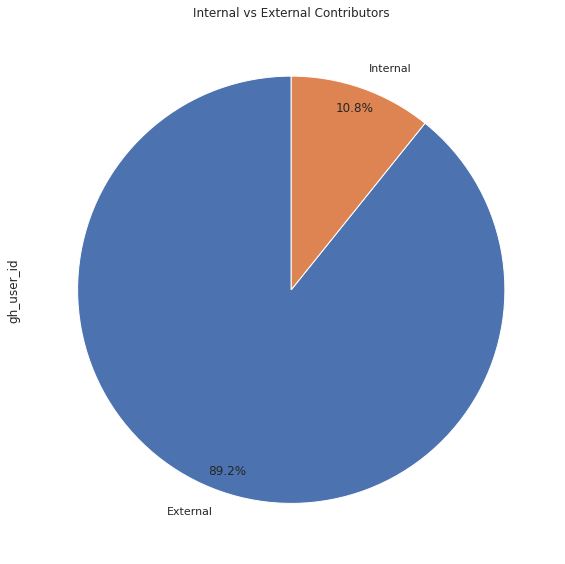

In [11]:
labels = ["External","Internal"]
cntrb_groups.plot.pie(figsize=(15,8),autopct='%1.1f%%',startangle=90,pctdistance=0.9,labels=labels)
plt.title("Internal vs External Contributors")
plt.tight_layout()
plt.show()

We have 108 (80.6%) external contributors and 26 (19.4%) internal contributors.

# Issues
We can also measure the size and growth of the community by analyzing the GitHub repository activities (issues and PRs) by tracking the GitHub issue activity across repositories such as number of issues created over time, number of issues closed over time, number of issues created by internal vs external contributors etc.

We will fetch the data from the `issues` table which contains information pertaining to the issue activity across repositories such as issue creation time, issue closed time, repository ID, GitHub user ID etc.

In [12]:
START_DATE = '2020-01-01'
END_DATE = '2021-12-31'

In [13]:
issues = pd.DataFrame()

repo_query = salc.sql.text(f"""
             SET SCHEMA 'augur_data';
             SELECT * FROM issues
             WHERE repo_id IN {tuple(repo_id_list)}
    """)

issues = pd.read_sql(repo_query, con=engine)
issues = issues[(issues['created_at'] >= START_DATE) & (issues['created_at']<=END_DATE)]

In [14]:
# Retain only relvant columns of interest
issues_columns = ['issue_id', 'repo_id', 'gh_user_id', 'created_at', 'closed_at']
issues = issues[issues_columns]

In [15]:
# Join repository details
issues_repo = issues.set_index('repo_id').join(repolist.set_index('repo_id')).reset_index()

In [16]:
# Join contributor details
issues_repo_cont = issues_repo.set_index('gh_user_id').join(contributors.set_index('gh_user_id')).reset_index()

In [17]:
issues_repo_cont = issues_repo_cont[issues_repo_cont['repo_name'] != "alerts"]

In [18]:
issues_repo_cont

,gh_user_id,repo_id,issue_id,created_at,closed_at,repo_name,cntrb_id,cntrb_full_name,cntrb_internal
0,36604,25437,352816,2021-08-12 12:47:52,NaT,SRE,277150,Robert Bohne,False
1,36604,25448,353554,2021-08-08 09:28:31,NaT,support,277150,Robert Bohne,False
2,36604,25448,353557,2021-08-08 09:18:32,NaT,support,277150,Robert Bohne,False
3,36604,25448,353588,2021-07-14 13:20:59,NaT,support,277150,Robert Bohne,False
4,36604,25448,353550,2021-08-08 10:16:17,2022-01-07 18:22:07,support,277150,Robert Bohne,False
...,...,...,...,...,...,...,...,...,...
29561,89909507,25450,366550,2021-10-25 13:55:02,2021-11-19 18:35:27,apps,277250,Thor*sten Schwesig,False
29562,89909507,25450,366390,2021-11-29 20:45:17,2021-11-29 22:28:48,apps,277250,Thor*sten Schwesig,False
29563,89909507,25450,366551,2021-10-25 13:53:16,2021-11-02 16:54:12,apps,277250,Thor*sten Schwesig,False
29564,89909507,25452,366847,2021-12-08 13:13:10,2021-12-09 17:59:19,hitchhikers-guide,277250,Thor*sten Schwesig,False


## Issues Created Over Time

Lets visualize the number of issues created over time per repository.

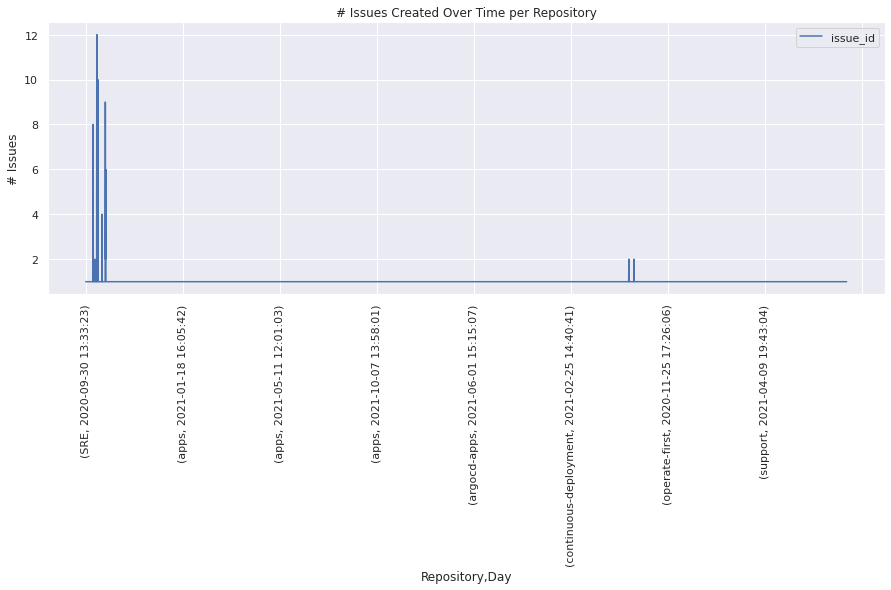

In [19]:
issues_repo_cont[['repo_name', 'created_at', 'issue_id']].groupby(['repo_name', 'created_at']).count().plot()
plt.xticks(rotation=90)
plt.xlabel("Repository,Day")
plt.ylabel("# Issues")
plt.title("# Issues Created Over Time per Repository")
plt.show()

Now let's try to visualize the number of monthly issues that were created across all repositories.

In [20]:
issues_repo_time = issues_repo_cont['repo_name'].groupby(issues_repo_cont.created_at.dt.to_period("M")).agg('count')

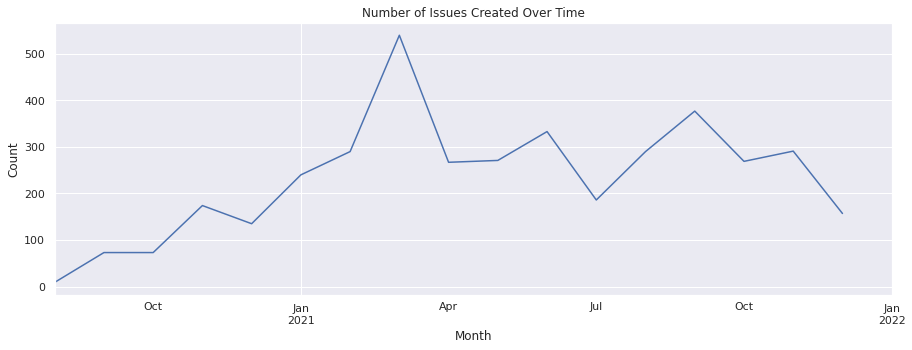

In [21]:
ax = issues_repo_time.plot()
ax.set_xlim(pd.Timestamp('2020-08-01'), pd.Timestamp('2022-01-31'))
plt.title("Number of Issues Created Over Time")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()

We see that over the year (2020-2021), we had an increase in the number of issues being created indicating an active community.

Now lets see the number of issues being created per repository.

In [22]:
issues_repo_gb = issues_repo_cont.groupby('repo_name')
issues_repo = pd.DataFrame()
issues_repo['internal'] = issues_repo_gb.apply(lambda x: x['cntrb_internal'].sum())
issues_repo['external'] = issues_repo_gb.apply(lambda x: len(x['cntrb_internal']) - x['cntrb_internal'].sum())

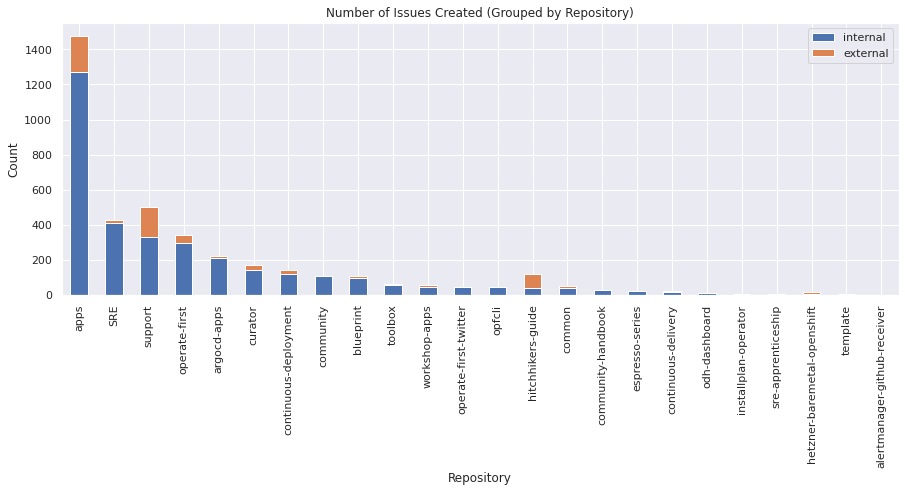

In [23]:
issues_repo.sort_values(by='internal', ascending=False).plot(kind='bar', stacked='True')
plt.title("Number of Issues Created (Grouped by Repository)")
plt.xlabel("Repository")
plt.ylabel("Count")
plt.show()

We see that the `alerts` repo has the highest number of issues being created. The `SRE, apps, support and operate-first` repositories are other repositories which are active.

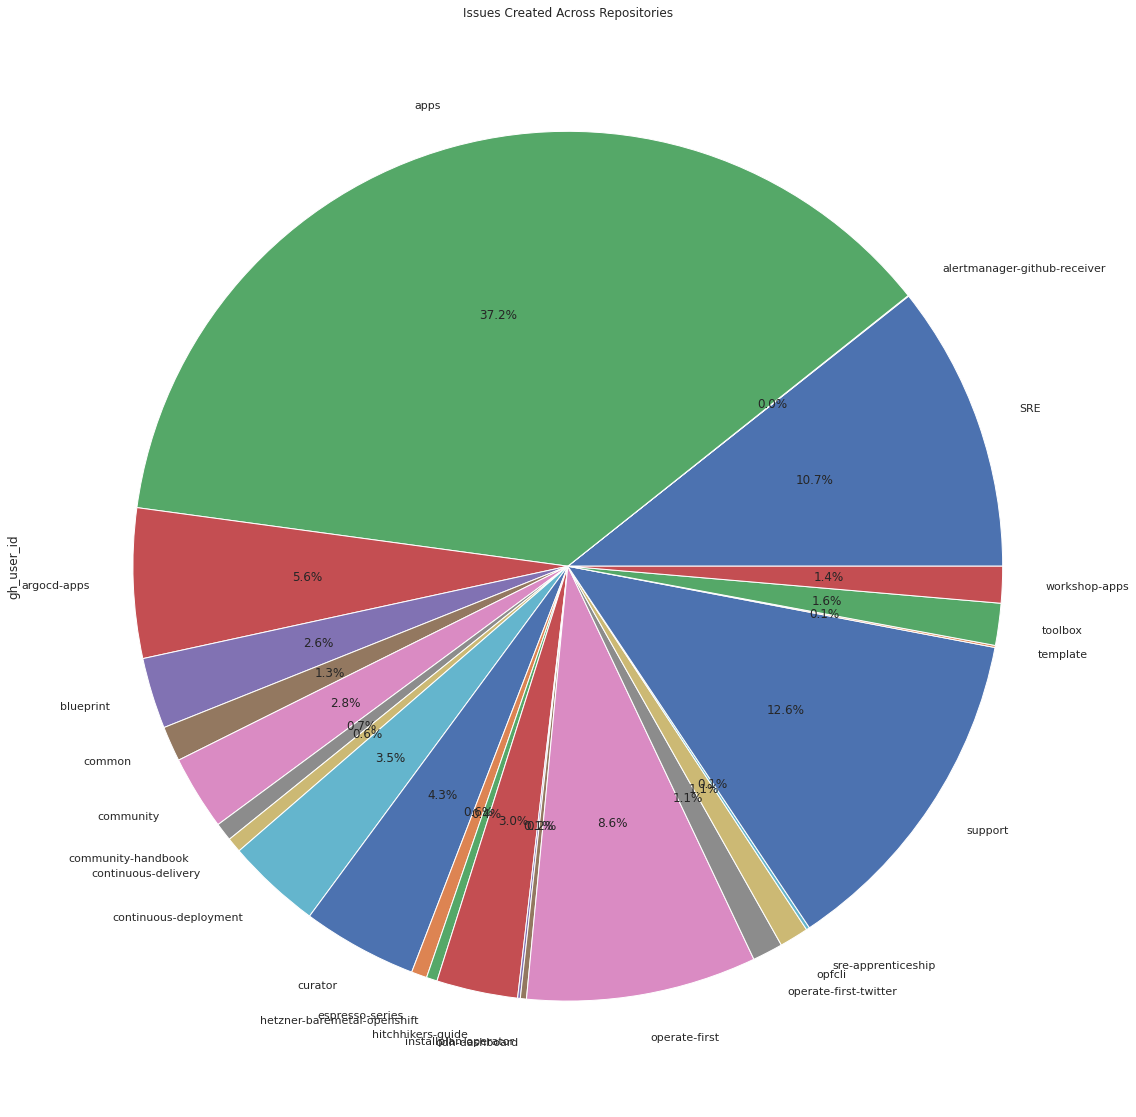

In [24]:
issues_repo_gb.gh_user_id.agg('count').plot.pie(figsize=(35,20),autopct='%1.1f%%')
plt.title("Issues Created Across Repositories")
plt.show()

We see that 85% of issues are being created in the `alerts` repository.

### Issues Created by External vs Internal Contributors
Let's see the distribution of issues opened by External and Internal contributors

In [25]:
issue_cntrb = issues_repo_cont['issue_id'].groupby(issues_repo_cont.cntrb_internal).agg('count')

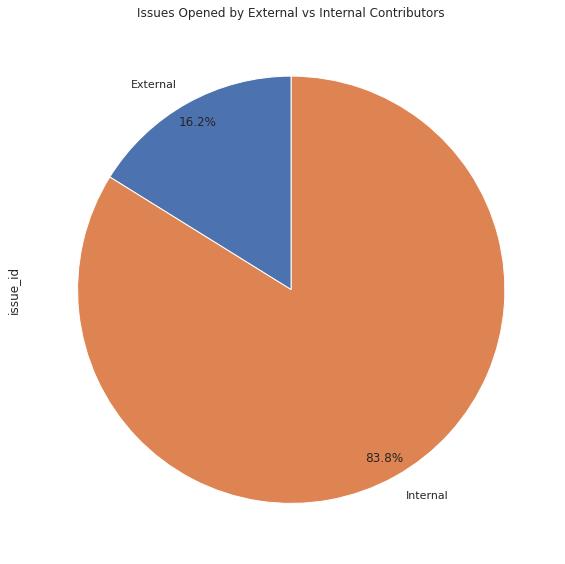

In [26]:
labels=["External","Internal"]
issue_cntrb.plot.pie(figsize=(15,8),autopct='%1.1f%%',startangle=90,pctdistance=0.9,labels=labels)
plt.title("Issues Opened by External vs Internal Contributors")
plt.tight_layout()
plt.show()

# PRs
We can also measure the size and growth of the community by analyzing the GitHub repository activities (issues and PRs) by tracking the GitHub PR activity across repositories such as number of PRs created over time, number of PRs closed over time, number of PRs created by internal vs external contributors etc.

We will fetch the data from the `pull_requests` and `pull_request_meta` tables which contains information pertaining to the PR activity across repositories such as PR creation time, PR closed time, repository ID, PR ID etc.

In [27]:
pr = pd.DataFrame()

repo_query = salc.sql.text(f"""
             SET SCHEMA 'augur_data';
             SELECT * FROM pull_requests
             WHERE repo_id IN {tuple(repo_id_list)}
    """)

pr = pd.read_sql(repo_query, con=engine)
pr = pr[(pr['pr_created_at'] >= START_DATE) & (pr['pr_created_at'] <= END_DATE)]

In [28]:
pr_meta = pd.DataFrame()

repo_query = salc.sql.text(f"""
             SET SCHEMA 'augur_data';
             SELECT * FROM pull_request_meta
    """)

pr_meta = pd.read_sql(repo_query, con=engine)

In [29]:
# Retain relevant columns
pr_columns = ['pull_request_id', 'pr_created_at', 'pr_closed_at', 'pr_merged_at', 'repo_id']
pr = pr[pr_columns]

In [30]:
pr_meta_columns = ['pull_request_id', 'cntrb_id']
pr_meta = pr_meta[pr_meta_columns]

In [31]:
# Join repository details
pr_repo = pr.set_index('repo_id').join(repolist.set_index('repo_id')).reset_index()

In [32]:
# Join contributor id
pr_repo_cid = pr_repo.set_index('pull_request_id').join(pr_meta.set_index('pull_request_id')).reset_index()

In [33]:
# Join contributor details
pr_repo_cid_cont = pr_repo_cid.set_index('cntrb_id').join(contributors.set_index('cntrb_id')).reset_index()

In [34]:
pr_repo_cid_cont

,cntrb_id,pull_request_id,repo_id,pr_created_at,pr_closed_at,pr_merged_at,repo_name,cntrb_full_name,gh_user_id,cntrb_internal
0,277109,209022,25431,2021-03-17 15:31:10,2021-03-17 15:58:04,2021-03-17 15:58:04,alerts,Tom Coufal,7453394,True
1,277109,209023,25431,2021-05-03 12:42:07,2021-05-03 13:30:33,2021-05-03 13:30:33,alerts,Tom Coufal,7453394,True
2,277109,209025,25430,2021-05-12 08:59:18,2021-05-12 13:37:14,2021-05-12 13:37:14,community,Tom Coufal,7453394,True
3,277109,209035,25432,2021-03-22 11:07:03,2021-03-22 12:49:55,2021-03-22 12:49:55,installplan-operator,Tom Coufal,7453394,True
4,277109,209036,25432,2021-03-29 09:15:43,2021-04-09 13:38:48,2021-04-09 13:38:48,installplan-operator,Tom Coufal,7453394,True
...,...,...,...,...,...,...,...,...,...,...
3418,277250,210592,25441,2021-10-11 15:05:33,2021-10-12 09:19:11,2021-10-12 09:19:11,operate-first-twitter,Thor*sten Schwesig,89909507,False
3419,277250,210624,25448,2021-10-15 12:27:01,2021-10-21 14:11:11,2021-10-21 14:11:11,support,Thor*sten Schwesig,89909507,False
3420,277258,210718,25445,2021-12-08 16:42:11,2022-01-11 14:49:29,2022-01-11 14:49:29,continuous-delivery,Ryan Cook,3812500,False
3421,277281,210577,25437,2021-10-26 13:38:28,2021-10-26 16:43:38,2021-10-26 16:43:38,SRE,axel simon,1172256,False


### PRs Created Over Time

Lets visualize the number of PRs created over time per repository.

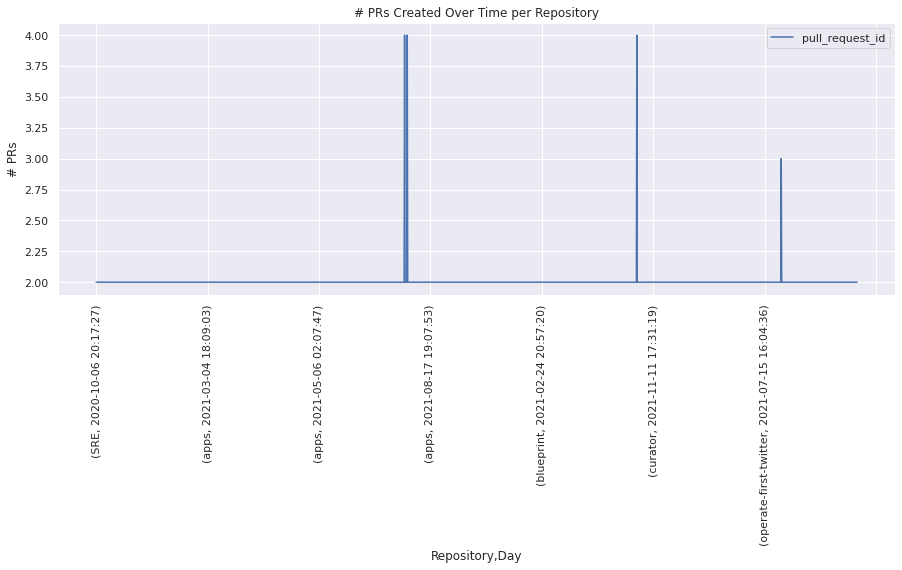

In [35]:
pr_repo_cid_cont[['repo_name', 'pr_created_at', 'pull_request_id']].groupby(['repo_name', 'pr_created_at']).count().plot()
plt.xticks(rotation=90)
plt.xlabel("Repository,Day")
plt.ylabel("# PRs")
plt.title("# PRs Created Over Time per Repository")
plt.show()

Let's try to visualize the number of monthly PRs that were created across all repositories.

In [36]:
prs_repo_time = pr_repo_cid_cont['repo_name'].groupby(pr_repo_cid_cont.pr_created_at.dt.to_period("M")).agg('count')

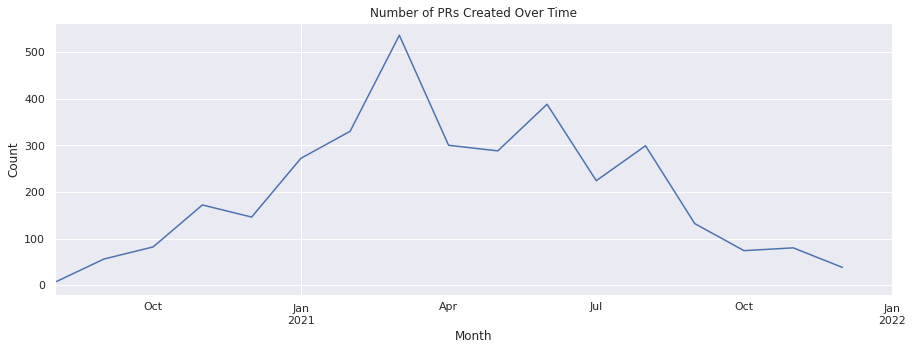

In [37]:
ax = prs_repo_time.plot()
ax.set_xlim(pd.Timestamp('2020-08-01'), pd.Timestamp('2022-01-31'))
plt.title("Number of PRs Created Over Time")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()

In [38]:
pr_repo_cid_cont

,cntrb_id,pull_request_id,repo_id,pr_created_at,pr_closed_at,pr_merged_at,repo_name,cntrb_full_name,gh_user_id,cntrb_internal
0,277109,209022,25431,2021-03-17 15:31:10,2021-03-17 15:58:04,2021-03-17 15:58:04,alerts,Tom Coufal,7453394,True
1,277109,209023,25431,2021-05-03 12:42:07,2021-05-03 13:30:33,2021-05-03 13:30:33,alerts,Tom Coufal,7453394,True
2,277109,209025,25430,2021-05-12 08:59:18,2021-05-12 13:37:14,2021-05-12 13:37:14,community,Tom Coufal,7453394,True
3,277109,209035,25432,2021-03-22 11:07:03,2021-03-22 12:49:55,2021-03-22 12:49:55,installplan-operator,Tom Coufal,7453394,True
4,277109,209036,25432,2021-03-29 09:15:43,2021-04-09 13:38:48,2021-04-09 13:38:48,installplan-operator,Tom Coufal,7453394,True
...,...,...,...,...,...,...,...,...,...,...
3418,277250,210592,25441,2021-10-11 15:05:33,2021-10-12 09:19:11,2021-10-12 09:19:11,operate-first-twitter,Thor*sten Schwesig,89909507,False
3419,277250,210624,25448,2021-10-15 12:27:01,2021-10-21 14:11:11,2021-10-21 14:11:11,support,Thor*sten Schwesig,89909507,False
3420,277258,210718,25445,2021-12-08 16:42:11,2022-01-11 14:49:29,2022-01-11 14:49:29,continuous-delivery,Ryan Cook,3812500,False
3421,277281,210577,25437,2021-10-26 13:38:28,2021-10-26 16:43:38,2021-10-26 16:43:38,SRE,axel simon,1172256,False


Now, let's see the number of PRs created per repository.

In [39]:
prs_repo_gb = pr_repo_cid_cont.groupby('repo_name')
prs_repo = pd.DataFrame()
prs_repo['internal'] = prs_repo_gb.apply(lambda x: x['cntrb_internal'].sum())
prs_repo['external'] = prs_repo_gb.apply(lambda x: len(x['cntrb_internal']) - x['cntrb_internal'].sum())

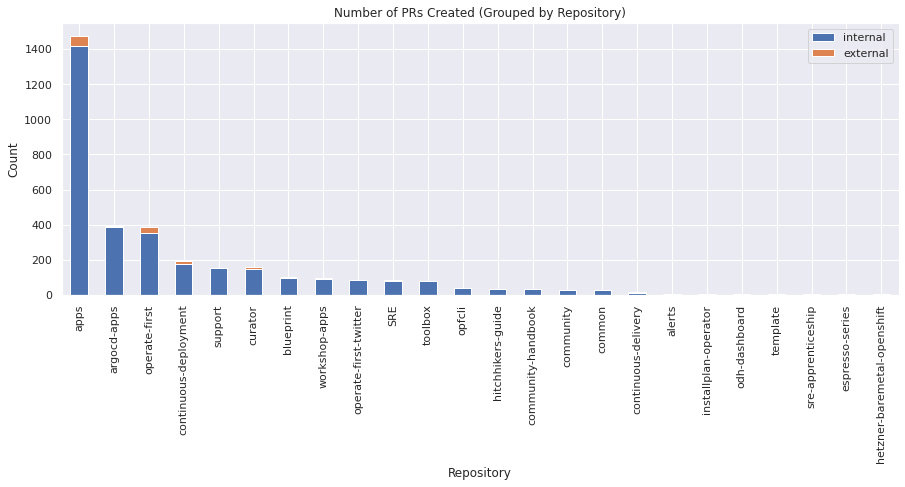

In [40]:
prs_repo.sort_values(by='internal', ascending=False).plot(kind='bar', stacked='True')
plt.title("Number of PRs Created (Grouped by Repository)")
plt.xlabel("Repository")
plt.ylabel("Count")
plt.show()

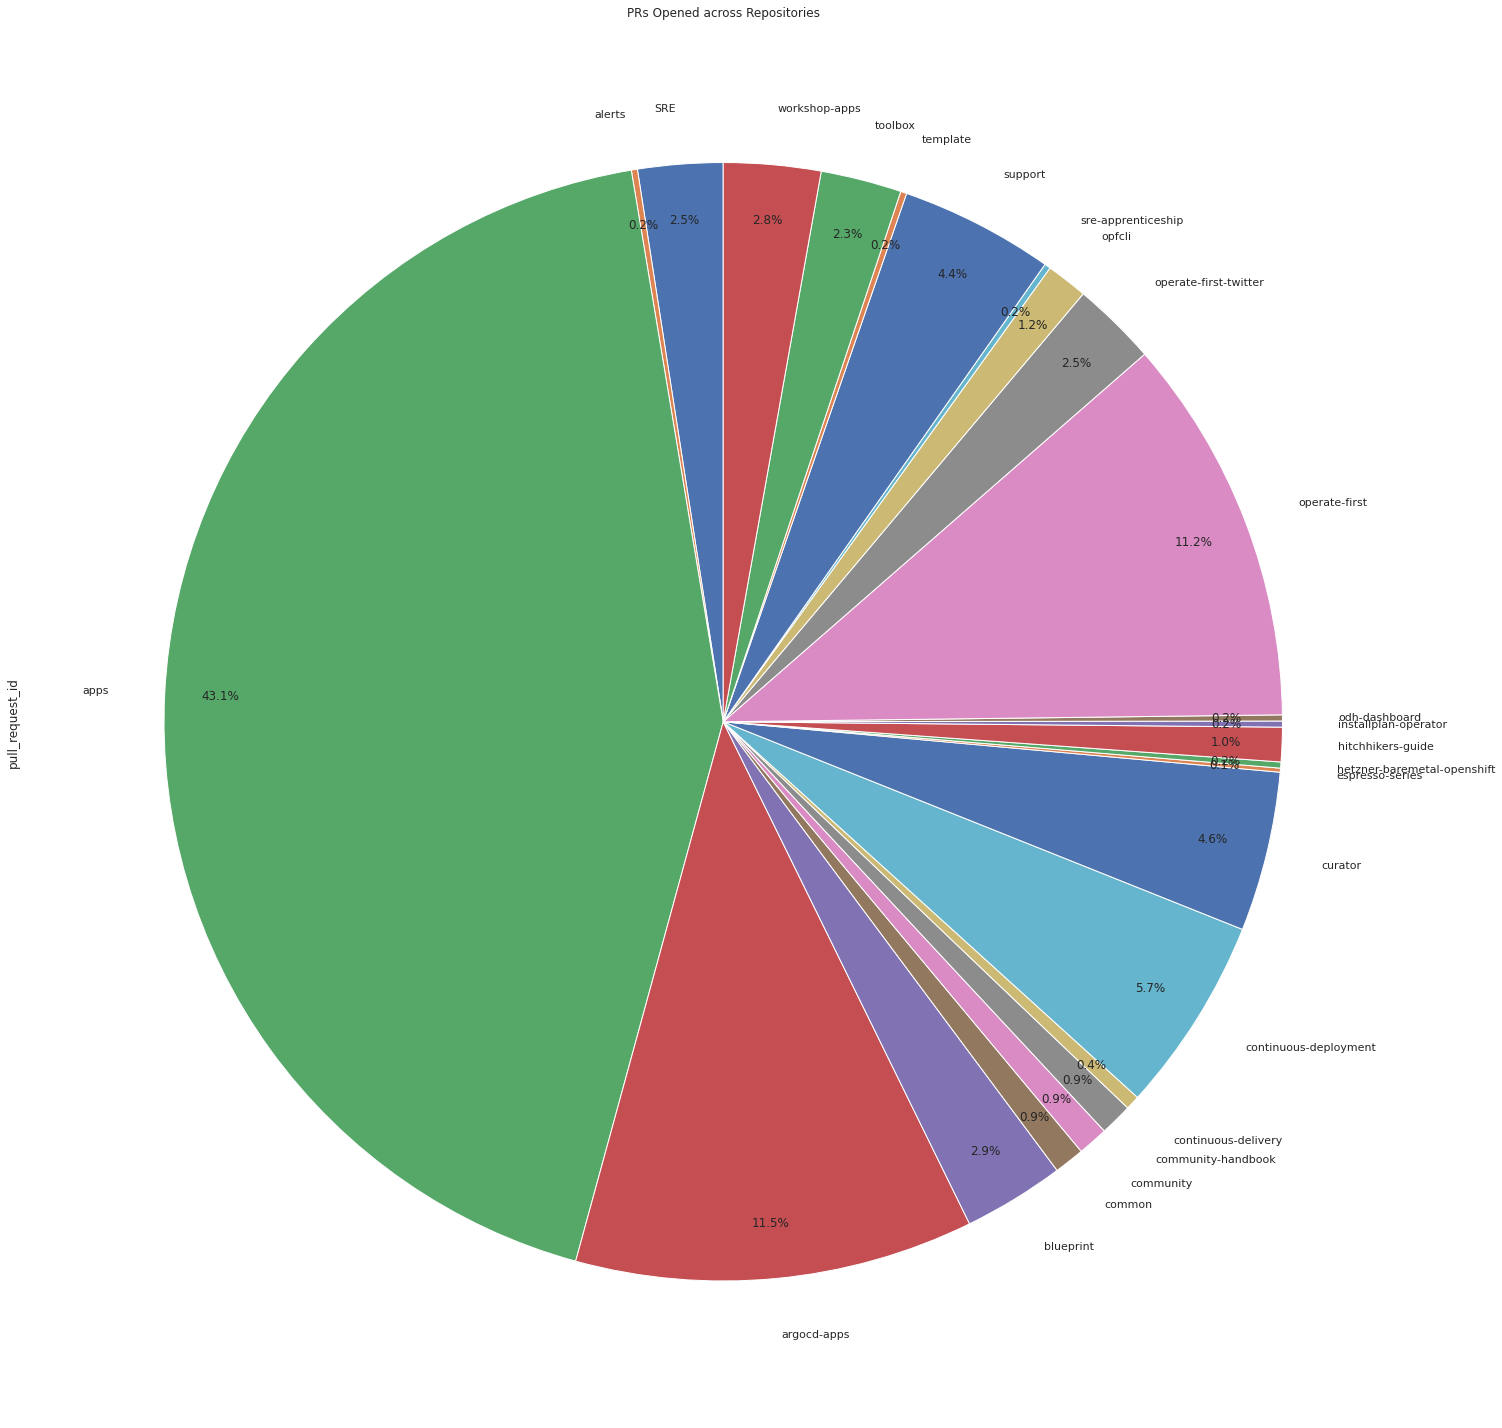

In [41]:
prs_repo_gb.pull_request_id.agg('count').plot.pie(figsize=(35,20),autopct='%1.1f%%',startangle=90,pctdistance=0.9)
plt.title("PRs Opened across Repositories")
plt.tight_layout()
plt.show()

### PRs Created By External vs Internal Contributors
Let's see the distribution of PRs opened by External and Internal contributors

In [42]:
pr_cntrb = pr_repo_cid_cont['pull_request_id'].groupby(pr_repo_cid_cont.cntrb_internal).agg('count')

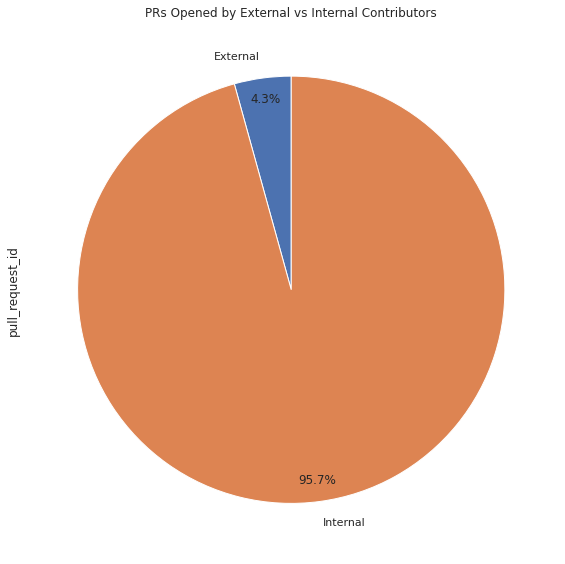

In [43]:
labels = ["External","Internal"]
pr_cntrb.plot.pie(figsize=(15,8),autopct='%1.1f%%',startangle=90,pctdistance=0.9,labels=labels)
plt.title("PRs Opened by External vs Internal Contributors")
plt.tight_layout()
plt.show()

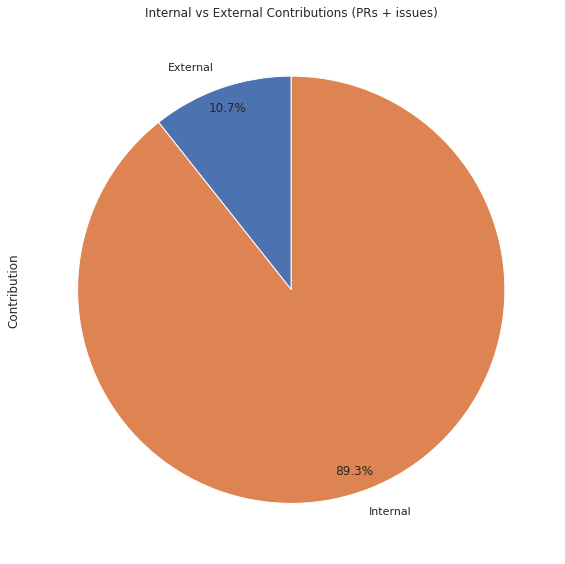

In [44]:
irc = issues_repo_cont[['issue_id', 'cntrb_internal']].rename(columns={'issue_id':'Contribution'})
prc = pr_repo_cid_cont[['pull_request_id', 'cntrb_internal']].rename(columns={'pull_request_id':'Contribution'})
iprc = pd.concat([irc, prc])
iprc_groups = iprc.groupby('cntrb_internal').agg('count')['Contribution']

labels = ["External","Internal"]
iprc_groups.plot.pie(figsize=(15,8),autopct='%1.1f%%',startangle=90,pctdistance=0.9,labels=labels)
plt.title("Internal vs External Contributions (PRs + issues)")
plt.tight_layout()
plt.show()

This shows that 90.9% of contributions (PRs + issues) are made by internal contributors and 9.1% by external contributors

# Conclusion

In this notebook, we collected and visualized community metrics for the Operate First group repositories. We connected to the Augur database to fetch data about github contributions such as issues and PRs. The visualizations can be used to understand community engagement of the group. 